In [1]:
import pandas as pd
dataset = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


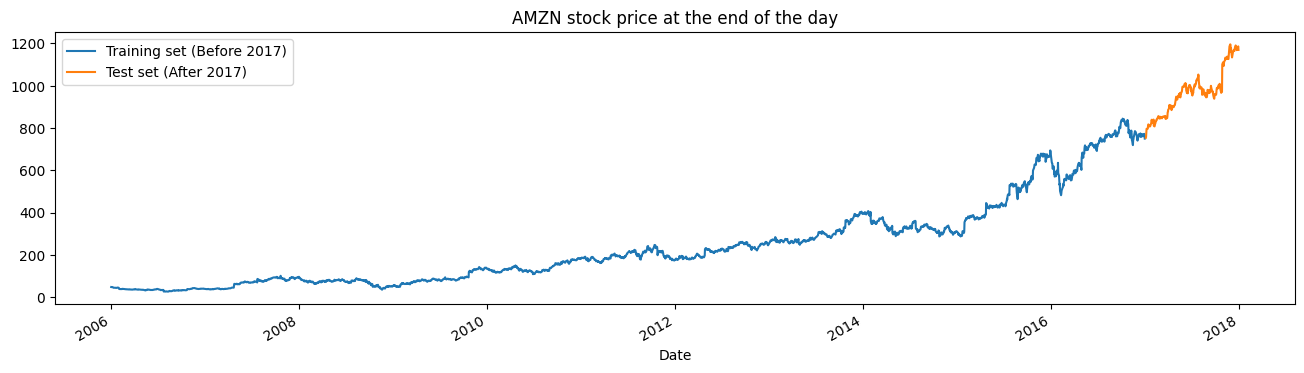

In [2]:
import matplotlib.pyplot as plt
dataset["Close"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (After 2017)'])
plt.title('AMZN stock price at the end of the day')
plt.show()

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Filter only the 'Close' feature
dataset = dataset.filter(['Close'])
# Scale the 'Close' values in the range [0,1]
mmscaler = MinMaxScaler(feature_range=(0,1))
mmscaler.fit(dataset.Close.values.reshape(-1,1))
scaled_data = mmscaler.transform(dataset.values)
# Deciding the split point to be at year 2016
split_point = len(dataset[:'2016'])

In [4]:
import numpy as np

WIN_SIZE = 60

train_data = scaled_data[:split_point, :]
x_train = []
y_train = []

# Creating the basic data structure
for i in range(WIN_SIZE, len(train_data)):
    x_train.append(train_data[i-WIN_SIZE:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(x_train, y_train, batch_size=1, epochs=1)



2708/2708 [==============================] - 78s 28ms/step - loss: 7.9652e-04


In [7]:
test_data = scaled_data[len(train_data) - 60:, :]
x_test = []
y_test = test_data
for i in range(WIN_SIZE, len(test_data)):
    x_test.append(test_data[i-WIN_SIZE:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

8/8 [==============================] - 3s 41ms/step


C:\Users\fedcal\AppData\Local\Temp\ipykernel_2916\514159473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


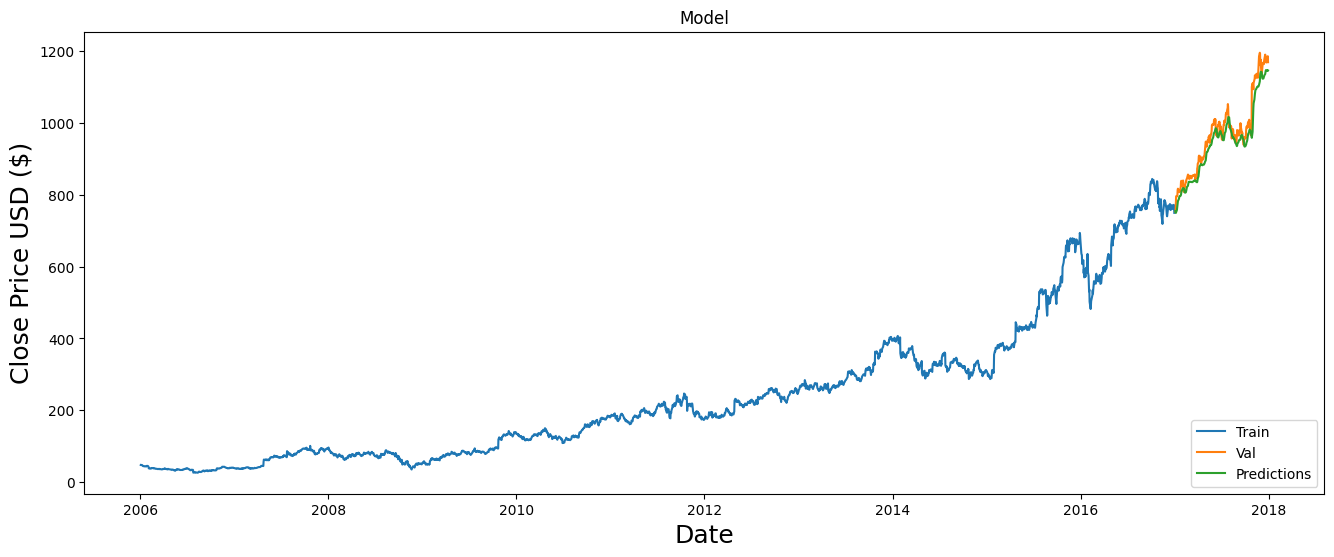

In [8]:
# Plot the data
train = dataset[:split_point]
valid = dataset[split_point:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()